# Entropy Analysis of the 4x3 lexicons for both the Ostensive and the Non-Ostensive simulations.

Let's start with importing the packages we need to read in the data and be able to generate the images.

In [79]:
#imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as st

Let's create the mechanisms for reading in the existing data. The config file contains the configurations for this particular output file.

In [80]:
# config.csv:
# agentPairs;maxTurns;roundsPlayed;beta;entropyThreshold;
#  order;costs;initiatorDistribution;responderDistribution
def read_config(location, config_title):
    filename = location + "config" + config_title + ".csv"
    with open(filename) as f:
        config = pd.read_csv(filename, sep=";")
    return config

Next, we have the data that reports on the end result of each round of interaction, for all of the agents. This entails both the number of turns the agents use before they believe to understand each other, as well as whether they had success in their communication.

In [81]:
# results_rounds.csv: 
# pair;round;nrTurns;success
def read_results_rounds(location, config_title):
    filename = location + "results_rounds" + config_title + ".csv"
    with open(filename) as f:
        results_rounds = pd.read_csv(filename, sep=";")
    return results_rounds

Finally, for this set, we have the rest of the data. This is a lot larger, and contains all the information recorded throughout all interactions. So where the above contains only the results per round of interaction, this dataset contains all the information of what happens in each turn of the conversation.

In [82]:
# results_turns.csv: 
# pair;round;turn;initiatorIntention;initiatorSignal;
# responderInference;responderSignal;entropyInitiatorListen;entropyResponderListen;
# entropyInitiatorLexicon;entropyResponderLexicon;KLDivItoR;KLDivRtoI
def read_results_turns(location, config_title):
    filename = location + "results_turns" + config_title + ".csv"
    with open(filename) as f:
        results_turns = pd.read_csv(filename, sep=";")
    return results_turns

Now to gather the specific data we need. Analyses are currently on one configuration with settings: 4x3 lexicon size, binomial distribution with an X of 0.45 and 0.55, an alpha of 5, and 500 agents. This will of course be run for both the Ostensive Signalling model as well as the Pragmatic Updating model.

In [83]:
pragmatic_model_title = "_a500_b5.0_d0.45"
pragmatic_model_location = "data/"

ostensive_model_title = "_exp_a500_b5.0_d0.45"
ostensive_model_location = "data/"


We can now import all the necessary datasets. First: the results_turns set include the data for every turn of the dialogue, and is the most detail level information.

In [84]:
pragmatic_results_turns = read_results_turns(pragmatic_model_location, pragmatic_model_title)
ostensive_results_turns = read_results_turns(ostensive_model_location, ostensive_model_title)

The labelling of turns is off slightly because of how the models was built, the below code fixes that (do not run it extra without reloading the data, else the +1 row will throw everything off)

In [85]:
for i, row in pragmatic_results_turns.iterrows():
    if row["turn"] == 0 and np.isnan(row["entropyInitiatorListen"]):
        pragmatic_results_turns.at[i,"turn"] = -1
pragmatic_results_turns["turn"] = [x+1 for x in pragmatic_results_turns["turn"]]

for i, row in ostensive_results_turns.iterrows():
    if row["turn"] == 0 and np.isnan(row["entropyInitiatorListen"]):
        ostensive_results_turns.at[i,"turn"] = -1
ostensive_results_turns["turn"] = [x+1 for x in ostensive_results_turns["turn"]]

Next, we take the results on a dialogue level. These contain the result of the dialogue. Before we continue, we merge the results_rounds with the useful information from the results_turns. This way, while looking at a turns level, we still have access to the information on how long a conversation was, and its success.

In [86]:
pragmatic_results_rounds = read_results_rounds(pragmatic_model_location, pragmatic_model_title)
ostensive_results_rounds = read_results_rounds(ostensive_model_location, ostensive_model_title)

In [87]:
pragmatic_results_merged = pragmatic_results_rounds.merge(pragmatic_results_turns, left_on=['pair', 'round'], right_on=['pair', 'round'])
ostensive_results_merged = ostensive_results_rounds.merge(ostensive_results_turns, left_on=['pair', 'round'], right_on=['pair', 'round'])

Adding disambiguation between the models and putting them in one dataframe for some of the image creation.

In [98]:
ostensive_results_rounds['model'] = "Ostensive"
pragmatic_results_rounds['model'] = "Non-Ostensive"
mixed_results_rounds = pd.concat([pragmatic_results_rounds, ostensive_results_rounds])


Removing all cases where the agents gave up, as that is not representative of a clarification sequence length.

In [99]:
mixed_results_rounds = mixed_results_rounds[mixed_results_rounds['nrTurns'] < 7]

The main image for analysis 1 in the attached paper:

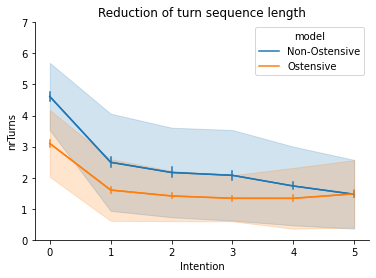

In [101]:
f = sns.lineplot(data=mixed_results_rounds, x="round", y="nrTurns", hue="model", err_style="bars")
c = sns.lineplot(data=mixed_results_rounds, x="round", y="nrTurns", hue="model", ci='sd', legend=False)
sns.despine()
f.set_ylim([0,7])
f.set_xlabel("Intention")
f.set_title("Reduction of turn sequence length")

The images below show the factual understanding the agents have, dependent on the turn in which they decide to alter the conversation. (This is the analysis 2 in the paper).

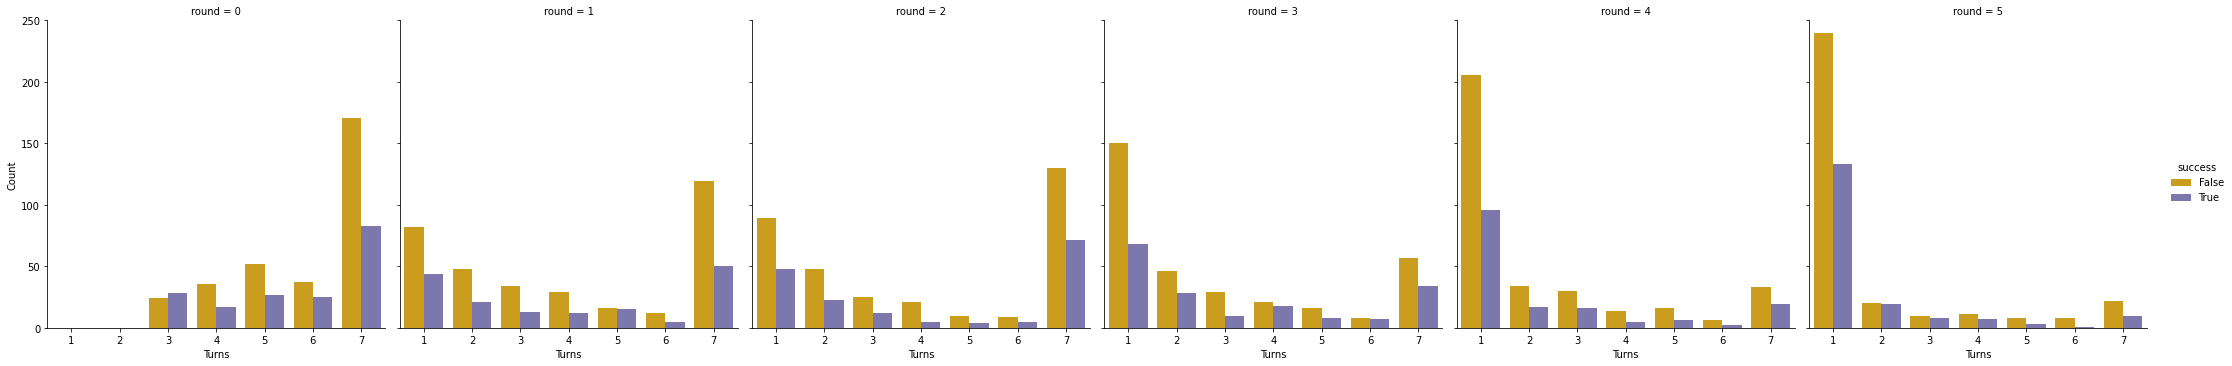

In [89]:
f = sns.catplot(x="nrTurns", hue="success", col="round", data=pragmatic_results_rounds, kind="count", palette="Dark2_r")
(f.set_axis_labels("Turns", "Count")
  .set(ylim=(0, 250)))  

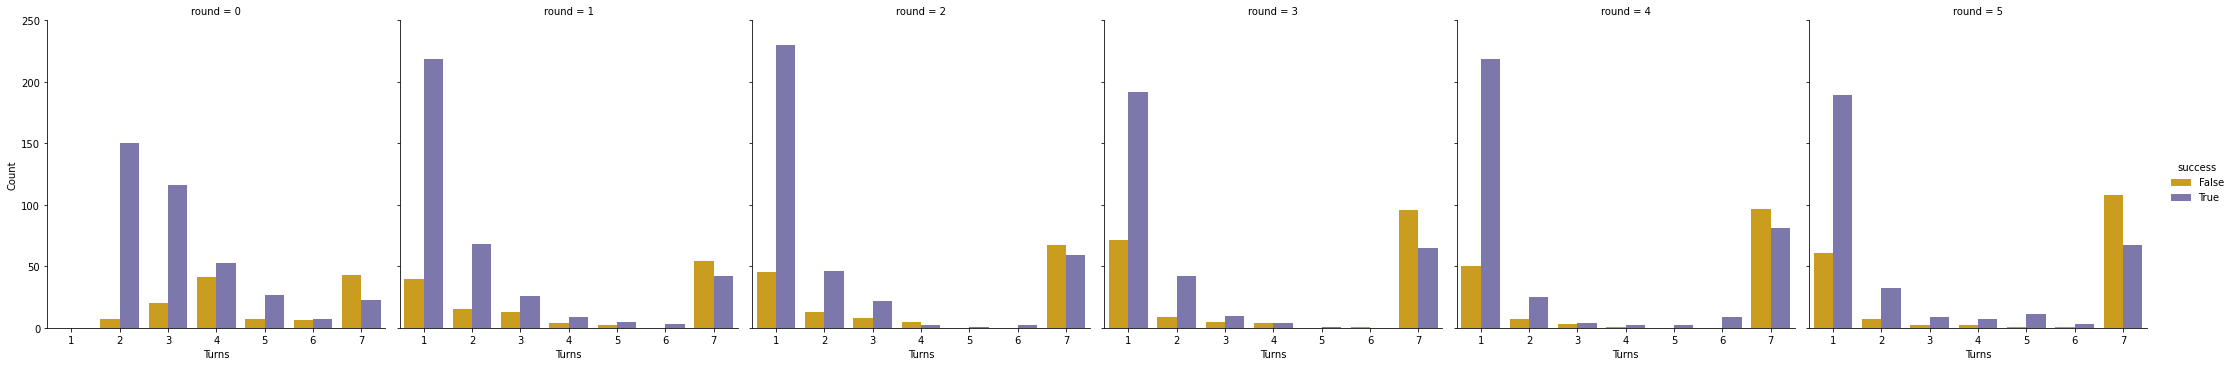

In [90]:
f = sns.catplot(x="nrTurns", hue="success", col="round", data=ostensive_results_rounds, kind="count", palette="Dark2_r")
(f.set_axis_labels("Turns", "Count")
  .set(ylim=(0, 250)))  

Below follow the information to create tables of factual vs perceived understanding (analysis 3)

In [91]:
perceived_understanding_prag = pragmatic_results_rounds[pragmatic_results_rounds.nrTurns <= 6]
perceived_misunderstanding_prag = pragmatic_results_rounds[pragmatic_results_rounds.nrTurns > 6]
print(perceived_understanding_prag[perceived_understanding_prag.success == True].count())
print(perceived_understanding_prag[perceived_understanding_prag.success == False].count())
print(perceived_misunderstanding_prag[perceived_misunderstanding_prag.success == True].count())
print(perceived_misunderstanding_prag[perceived_misunderstanding_prag.success == False].count())

pair       756
round      756
nrTurns    756
success    756
dtype: int64
pair       1445
round      1445
nrTurns    1445
success    1445
dtype: int64
pair       267
round      267
nrTurns    267
success    267
dtype: int64
pair       532
round      532
nrTurns    532
success    532
dtype: int64


| Non-Ostensive ||| Perceived understanding | Give up  |
| ------------- ||| -------------:|-------------: |
| factual understanding   ||| 756           | 267           |
| factual misunderstanding    ||| 1445          |   532         |



And for the ostensive case

In [92]:
perceived_understanding_ost = ostensive_results_rounds[ostensive_results_rounds.nrTurns <= 6]
perceived_misunderstanding_ost = ostensive_results_rounds[ostensive_results_rounds.nrTurns > 6]
print(perceived_understanding_ost[perceived_understanding_ost.success == True].count())
print(perceived_understanding_ost[perceived_understanding_ost.success == False].count())
print(perceived_misunderstanding_ost[perceived_misunderstanding_ost.success == True].count())
print(perceived_misunderstanding_ost[perceived_misunderstanding_ost.success == False].count())

pair       1747
round      1747
nrTurns    1747
success    1747
dtype: int64
pair       451
round      451
nrTurns    451
success    451
dtype: int64
pair       337
round      337
nrTurns    337
success    337
dtype: int64
pair       465
round      465
nrTurns    465
success    465
dtype: int64


| Ostensive     ||| Perceived understanding | Give up  |
| ------------- ||| -------------:|-------------: |
| factual understanding   ||| 1747          | 337           |
| factual misunderstanding    ||| 451           |   465         |

In percentages:

| Non-Ostensive ||| Perceived understanding | Give up  |
| ------------- ||| -------------:|-------------: |
| factual understanding   ||| 25.20 %       | 8.90 %        |
| factual misunderstanding    ||| 48.17 %       | 17.73 %       |

| Ostensive     ||| Perceived understanding | Give up |
| ------------- ||| -------------:|-------------: |
| factual understanding   ||| 58.23 %       | 11.23 %       |
| factual misunderstanding    ||| 15.03 %       |  15.5 %       |

Below is the final analysis 3: showing percentage of factual understanding split by whether the agents perceived understanding or gave up.

|               ||| Perceived understanding | Give up      |
| ------------- ||| -----------------------:|-------------:|
| ostensive     ||| 79.5 %                  | 42.0 %       |
| non-ostensive ||| 34.4 %                  | 33.4 %       |